# Computing stress-strain curves

This tutorial will cover:

* Computing stress-strain curves
* Passing an initial guess to the steady solver

It is often useful to examine how the elastic stresses depend on the strain.  This tutorial will showcase how that can be done.

In [1]:
import ucompress as uc
import numpy as np
import matplotlib.pyplot as plt

## Example 1 - Instantaneous strain-stress curve for a neo-Hookean material

In the first example, we keep things simple and calculate the stress-strain curve for a neo-Hookean material subject to an instantaneous response.  We first load in the parameters and the mechanics model.  We do not load a permeability model since this is not required for this work.

In [2]:
# Define parameters, mechanics, permeability
pars = uc.parameters.example_parameters.NeoHookean()
mech = uc.mechanics.NeoHookean()
perm = None

# Build the model
model = uc.base_models.Poroelastic(mech, perm, pars)

During an instantaneous load, fluid does not leave the sample so the material undergoes a volume-conserving deformation such that $\lambda_r^2 \lambda_z = 1$.  Therefore, we define the axial stretches $\lambda_z$ and then work out the corresponding radial stretches

In [3]:
lam_z = np.linspace(0.5, 1.5, 30)
lam_r = 1 / np.sqrt(lam_z)

Next, we calculate the three components of the elastic stress tensor as follows

In [4]:
S_r, S_t, S_z = model.mechanics.eval_stress(lam_r, lam_r, lam_z)

Finally, we plot:

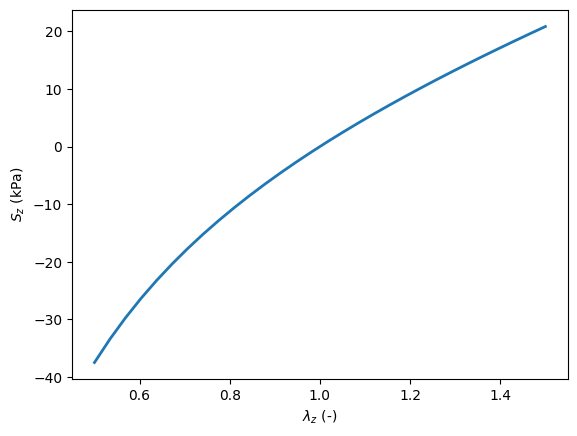

In [5]:
plt.plot(lam_z, S_z / 1e3, lw = 2)
plt.xlabel(r'$\lambda_z$ (-)')
plt.ylabel(r'$S_z$ (kPa)')
plt.show()

## Example 2 - Equilibrum strain-stress curve for a neo-Hookean material

Now, we compute the equilibrium stress-strain curve.  This case is more complicated because it required repeatedly solving for the equilibrium response to obtain the stretches.  Then, the stress components can be computed as in Example 1.

We first define the range of axial stretches that will be used to compute the stress-strain curve

In [6]:
Lam_z = np.linspace(0.5, 1.5, 30)

The stress-strain curve is computed by calculating the equilibrium (steady) response using a displacement-controlled experiment across the range of axial stretches previously defined.  When calling the method to compute the equilibrium response, we use the previously computed solution as the initial guess to help with convergence.  The solution object contains the axial stretch $\lambda_z$ and the Jacobian determinant $J = \lambda_r \lambda_\theta \lambda_z$.  At equilibrium, $\lambda_\theta = \lambda_r$, so the radial stretch can be calculated from $\lambda_r = (J/\lambda_z)^{1/2}$.  

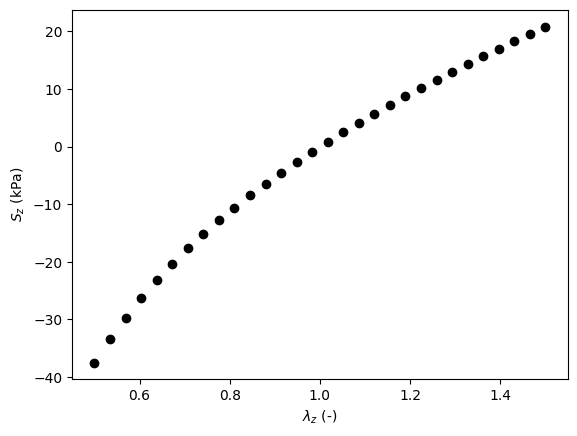

In [7]:
# Set the initial guess for the first solve
lam_r_0 = 1

# Loop over axial stretches
for lam_z in Lam_z:

    # Update parameters and model
    pars.update('lam_z', lam_z)
    model.assign(pars)

    # Define the experiment and solve for the steady response
    exp = uc.experiments.DisplacementControlled(model, pars)
    sol = exp.steady_response(lam_r_0)
    
    # Extract the Jacobian and calculate the radial stretches
    J = sol.J
    lam_r = np.sqrt(J/lam_z)

    # Evaluate the components of the elastic stress tensor
    S_r, S_t, S_z = model.mechanics.eval_stress(lam_r, lam_r, lam_z)

    # Plot the axial stretch and elastic stress
    plt.plot(lam_z, S_z / 1e3, 'ko')

    # Update the initial guess of the solution
    lam_r_0 = lam_r


plt.xlabel(r'$\lambda_z$ (-)')
plt.ylabel(r'$S_z$ (kPa)')
plt.show()